In [1]:
import os,sys
sys.path.append(os.path.abspath('../libraries/'))
from summary_utils import *
%pylab inline

db = '../data/data_complete.db'

Populating the interactive namespace from numpy and matplotlib


In [3]:
# load complete dataset and 
positives, length_positives = load_data_from_sqlite(db, 'positives')
negatives, length_negatives = load_data_from_sqlite(db, 'negatives')
print('positives: {} samples\nnegatives: {} samples'.format(length_positives[0], length_negatives[0]))

In [3]:
# Add this to try eliminating positive sequences without reads in bins 2 to 4
# These sequences might be noise
conn = sqlite3.connect(db)
cursor = conn.cursor()

cursor.execute('SELECT seq,ss FROM positives WHERE bin2>0 OR bin3>0 OR bin4>0')
positives = cursor.fetchall()
length_positives = [len(positives)]

In [4]:
# indices for positives and negatives
idx_positives = np.arange(length_positives[0])
idx_negatives = np.arange(length_negatives[0])

# shuffle indices
[np.random.shuffle(i) for i in [idx_positives, idx_negatives]]

# TEST set is 10% of positives and same number from negatives
# VALIDATION set is 10% of each (can subsample validation_negatives later)
_10p = int(length_positives[0]/10)
_10n = int(length_negatives[0]/10)

idx_test_p = idx_positives[:_10p]
idx_valid_p = idx_positives[_10p:_10p*2]
idx_train_p = idx_positives[_10p*2:]

idx_test_n = idx_negatives[:_10p]
idx_valid_n= idx_negatives[_10p:_10p+_10n]
idx_train_n = idx_negatives[_10p+_10n:]

In [5]:
# define the positive and negative sets
ohe_positives = np.array([prepare_ohe(i) for i in positives])
ohe_negatives = np.array([prepare_ohe(i) for i in negatives])

In [6]:
# create one numpy_map array for positives and 12 for negatives
p = ohe_positives[idx_train_p]
p_train, p_filename = store_data_numpy(p)

# set the positive validation array
p_valid = ohe_positives[idx_valid_p]
p_test = ohe_positives[idx_test_p]

# negatives. SQL indexes start with 1 and not 0
N = 10 #divisors[-1]
idxs = np.array(idx_train_n)
idxs = np.array_split(idxs, N) 

n_filenames = np.empty(N, dtype='O')
n_train = [np.zeros(shape=(i.shape[0],30,23), dtype=np.int8) for i in idxs]

for i in range(N):
    n = ohe_negatives[idxs[i]]
    n_train[i], n_filenames[i] = store_data_numpy(n)

# set the negative validation array 
n_valid = ohe_negatives[idx_valid_n]
n_test = ohe_negatives[idx_test_n]

# set a proper validation and test set with negatives and positives
X_valid = np.vstack([n_valid, p_valid])
y_valid = np.hstack([np.zeros(n_valid.shape[0]), np.ones(p_valid.shape[0])])
idx = np.random.permutation( np.arange(y_valid.shape[0]) )
X_valid, y_valid = X_valid[idx], y_valid[idx]

X_test = np.vstack([n_test, p_test])
y_test = np.hstack([np.zeros(n_test.shape[0]), np.ones(p_test.shape[0])])
idx = np.random.permutation( np.arange(y_test.shape[0]) )
X_test, y_test = X_test[idx], y_test[idx]

### Test Neural Networks 

In [7]:
import keras.backend as K
from keras.layers import Input, Dense, Conv2D, Flatten, GlobalMaxPooling2D, AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Model
from keras.activations import softmax, softplus, softsign, relu
from keras.callbacks import EarlyStopping
from keras import regularizers
import tensorflow as tf
from sklearn.metrics import roc_auc_score

def auc(y_true, y_pred):
    #return tf.py_func(roc_auc_score, (y_true, y_pred), tf.double)
    auc = tf.metrics.auc(y_true, y_pred)[1]  # using defaults parameters --> num_thresholds=200
    K.get_session().run(tf.local_variables_initializer())
    return auc

BS = 250 # samples/epoch

K.clear_session()

inputs = Input(shape=(30,23,1))
x = Conv2D(29, (4,23), activation=softplus)(inputs)
#x = MaxPooling2D((27,1))(x)
x = Flatten()(x)
#x = GlobalMaxPooling2D()(x)
x = Dense(300, activation=softplus)(x) 
x = Dropout(0.3)(x)
x = Dense(30, activation=softplus, kernel_regularizer=regularizers.l2(0.01))(x)
output = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[auc])
model.fit_generator(epoch_generator(n_train, p_train, batch_size=BS), 
                    validation_data=(X_test.reshape(np.insert(X_test.shape,3,1)), y_test),
                    steps_per_epoch=int(len(p_train)/BS),
                    epochs=100,
                    callbacks=[EarlyStopping(patience=3)],
                    verbose=0)

/app/easybuild/software/Python/3.6.5-foss-2016b-fh3/lib/python3.6/site-packages/h5py-2.7.1-py3.6-linux-x86_64.egg/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


### Check training and validation score

ROC_AUC validation (including more negatives than positives): 0.98
Saved model to disk


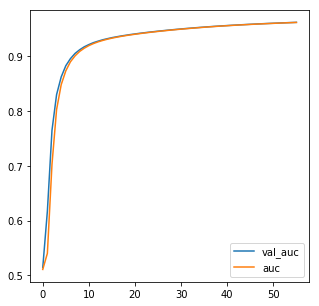

In [8]:
y_hat = model.predict(X_valid.reshape( np.insert(X_valid.shape, 3, 1) ))
print('ROC_AUC validation (including more negatives than positives): {:.2f}'.format(roc_auc_score(y_valid, y_hat)))

# plot training auc_roc
plt.figure(figsize=(5,5))
plt.plot(model.history.history['val_auc'], label='val_auc')
plt.plot(model.history.history['auc'], label='auc')
plt.legend();

# serialize model to json
model_json = model.to_json()
with open("../models/deep_model.json", "w") as json_file:
    json_file.write(model_json)
    
# serialize weights to HDF5
model.save_weights("../models/deep_model.h5")
print("Saved model to disk")